# CIFAR - 10
## Improved CNN

### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


Import helper functions

In [2]:
from helper import get_class_names, get_train_data, get_test_data, plot_images
from helper import plot_model, predict_classes, visualize_errors

Change matplotlib graph style

In [3]:
matplotlib.style.use('ggplot')

### Constants

Import class names

In [4]:
class_names = get_class_names()
print(class_names)

Decoding file: data/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Get number of classes

In [5]:
num_classes = len(class_names)
print(num_classes)

10


In [6]:
# Hight and width of the images
IMAGE_SIZE = 32

# 3 channels, Red, Green and Blue
CHANNELS = 3

# Number of epochs
NUM_EPOCH = 350
# NUM_EPOCH = 10

# learning rate
LEARN_RATE = 1.0e-4

### Fetch and decode data

Load the training dataset. Labels are integers whereas class is one-hot encoded vectors.

In [7]:
images_train, labels_train, class_train = get_train_data()

Decoding file: data/data_batch_1
Decoding file: data/data_batch_2
Decoding file: data/data_batch_3
Decoding file: data/data_batch_4
Decoding file: data/data_batch_5


Load the testing dataset.

In [8]:
images_test, labels_test, class_test = get_test_data()

Decoding file: data/test_batch


In [9]:
print("Training set size:\t",len(images_train))
print("Testing set size:\t",len(images_test))

Training set size:	 50000
Testing set size:	 10000


The CIFAR-10 dataset has been loaded and consists of a total of 60,000 images and corresponding labels.

## Improving accuracy

### 1. Define a better CNN model

A pure CNN model from https://arxiv.org/pdf/1412.6806.pdf

In [10]:
def pure_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)))    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))    
    
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1, 1), padding='valid'))

    model.add(GlobalAveragePooling2D())
    
    model.add(Activation('softmax'))

    model.summary()
    
    return model

Build the model

In [11]:
model = pure_cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 192)       331968    
__________

#### Train model on the training data

Save the model after every epoch

In [12]:
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 

Configure the model for training

In [13]:
model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(lr=LEARN_RATE), # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy']) # Metrics to be evaluated by the model

For more information on categorical cross entropy loss function see - https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/

Fit the model on the data provided

In [14]:
model_details = model.fit(images_train, class_train,
                    batch_size = 128,
                    epochs = NUM_EPOCH, # number of iterations
                    validation_data= (images_test, class_test),
                    callbacks=[checkpoint],
                    verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 99s - loss: 1.9737 - acc: 0.2472 - val_loss: 1.7984 - val_acc: 0.3135
Epoch 2/10
50000/50000 [==============================] - 97s - loss: 1.6944 - acc: 0.3661 - val_loss: 1.6022 - val_acc: 0.4136
Epoch 3/10
50000/50000 [==============================] - 97s - loss: 1.5959 - acc: 0.4111 - val_loss: 1.5570 - val_acc: 0.4303
Epoch 4/10
50000/50000 [==============================] - 97s - loss: 1.5189 - acc: 0.4434 - val_loss: 1.4697 - val_acc: 0.4623
Epoch 5/10
50000/50000 [==============================] - 97s - loss: 1.4682 - acc: 0.4627 - val_loss: 1.4398 - val_acc: 0.4695
Epoch 6/10
50000/50000 [==============================] - 97s - loss: 1.4175 - acc: 0.4823 - val_loss: 1.3469 - val_acc: 0.5110
Epoch 7/10
50000/50000 [==============================] - 97s - loss: 1.3734 - acc: 0.5016 - val_loss: 1.2967 - val_acc: 0.5337
Epoch 8/10
50000/50000 [==============================

#### Evaluate the model

In [15]:
scores = model.evaluate(images_test, class_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 56.85%


#### Model accuracy and loss plots

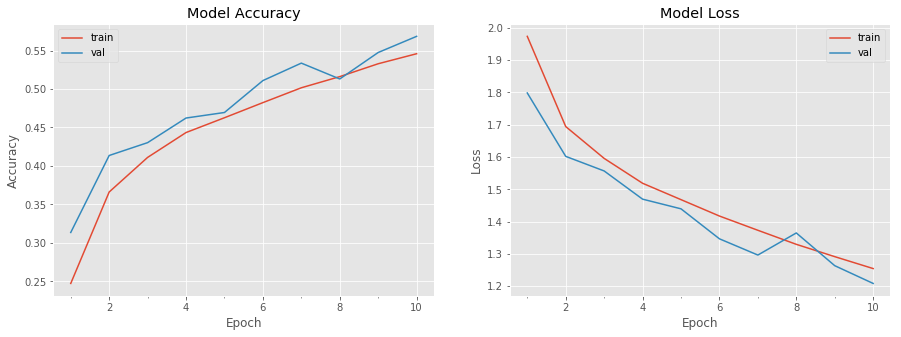

In [16]:
plot_model(model_details)

### 2. Augment the data

In [17]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(images_train)

The above code augments the dataset to have random shifts, rotations and flips, thus increasing the size of the dataset.

Build model again

In [18]:
augmented_model = pure_cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 192)       331968    
__________

#### Train model on the training data

Save the model after every epoch

In [19]:
augmented_checkpoint = ModelCheckpoint('augmented_best_model.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 

Configure the model for training

In [20]:
augmented_model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(lr=LEARN_RATE), # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy']) # Metrics to be evaluated by the model

Fit the model on the data provided

In [21]:
augmented_model_details = augmented_model.fit_generator(datagen.flow(images_train, class_train, batch_size = 32),
                    steps_per_epoch = len(images_train) / 32, # number of samples per gradient update
                    epochs = NUM_EPOCH, # number of iterations
                    validation_data= (images_test, class_test),
                    callbacks=[augmented_checkpoint],
                    verbose=1)

Epoch 1/10
1563/1562 [==============================] - 113s - loss: 1.9619 - acc: 0.2561 - val_loss: 1.7172 - val_acc: 0.3695
Epoch 2/10
1563/1562 [==============================] - 112s - loss: 1.7258 - acc: 0.3613 - val_loss: 1.5227 - val_acc: 0.4316
Epoch 3/10
1563/1562 [==============================] - 114s - loss: 1.5997 - acc: 0.4114 - val_loss: 1.4011 - val_acc: 0.4779
Epoch 4/10
1563/1562 [==============================] - 112s - loss: 1.5158 - acc: 0.4473 - val_loss: 1.3668 - val_acc: 0.5015
Epoch 5/10
1563/1562 [==============================] - 112s - loss: 1.4428 - acc: 0.4747 - val_loss: 1.2814 - val_acc: 0.5344
Epoch 6/10
1563/1562 [==============================] - 112s - loss: 1.3960 - acc: 0.4925 - val_loss: 1.1888 - val_acc: 0.5700
Epoch 7/10
1563/1562 [==============================] - 112s - loss: 1.3606 - acc: 0.5071 - val_loss: 1.1576 - val_acc: 0.5826
Epoch 8/10
1563/1562 [==============================] - 112s - loss: 1.3275 - acc: 0.5210 - val_loss: 1.1367 - 

#### Evaluate the model

In [22]:
scores = augmented_model.evaluate(images_test, class_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 59.63%


#### Model accuracy and loss plots

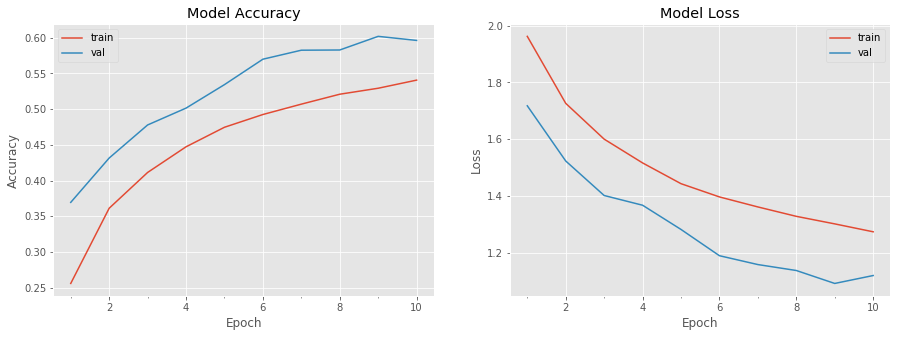

In [23]:
plot_model(augmented_model_details)

To further improve the model, run it for more epochs and do more augmentations like ZCA whitening. 

### Predictions

Predict class for test set images

In [24]:
correct, labels_pred = predict_classes(augmented_model, images_test, labels_test)

Calculate accuracy using manual calculation

In [25]:
num_images = len(correct)
print("Accuracy: %.2f%%" % ((sum(correct)*100)/num_images))

Accuracy: 59.63%


### Show some mis-classifications

Plot the first 9 mis-classified images

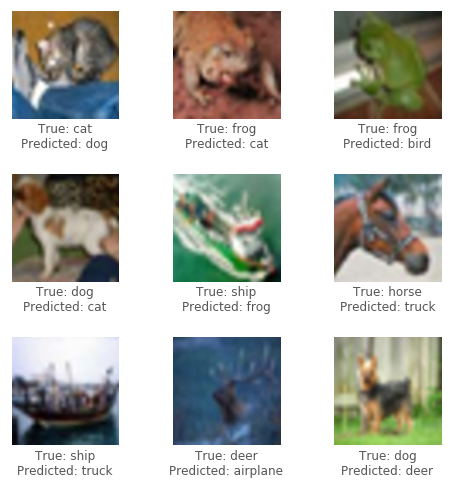

In [26]:
visualize_errors(images_test, labels_test, class_names, labels_pred, correct)

## Credits

 - https://arxiv.org/pdf/1412.6806.pdf
 - https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
 - https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
 - http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
 - https://parneetk.github.io/blog/cnn-cifar10/
 - https://github.com/dnlcrl/deep-residual-networks-pyfunt/blob/master/docs/CIFAR-10%20Experiments.ipynb